In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# --- 简化的 StripConv 用于测试 --- #
class StripConvTest(nn.Module):
    def __init__(self, kernel_size=3):
        super().__init__()
        pad = kernel_size // 2
        self.kernel_size = kernel_size

        self.conv_h = nn.Conv2d(1, 1, (1, kernel_size), padding=(0, pad), bias=False)
        self.conv_v = nn.Conv2d(1, 1, (kernel_size, 1), padding=(pad, 0), bias=False)
        self.conv_d1 = nn.Conv2d(1, 1, kernel_size, padding=pad, bias=False)  # 主对角线
        self.conv_d2 = nn.Conv2d(1, 1, kernel_size, padding=pad, bias=False)  # 副对角线

        # 初始化卷积核为全1，方便观察
        nn.init.constant_(self.conv_h.weight, 1.0)
        nn.init.constant_(self.conv_v.weight, 1.0)
        nn.init.constant_(self.conv_d1.weight, 0.0)
        nn.init.constant_(self.conv_d2.weight, 0.0)

        # 主对角线核
        for i in range(kernel_size):
            self.conv_d1.weight.data[0, 0, i, i] = 1.0
        # 副对角线核
        for i in range(kernel_size):
            self.conv_d2.weight.data[0, 0, i, kernel_size - 1 - i] = 1.0

    def forward(self, x):
        out_h = self.conv_h(x)
        out_v = self.conv_v(x)
        out_d1 = self.conv_d1(x)
        out_d2 = self.conv_d2(x)
        return out_h, out_v, out_d1, out_d2

# --- 生成 7x7 单通道输入图像 --- #
def generate_input():
    data = np.arange(49).reshape(1, 1, 7, 7).astype(np.float32)
    return torch.from_numpy(data)

# --- 打印结果为二维图像 --- #
def print_tensor(name, tensor):
    array = tensor.squeeze().detach().numpy()
    print(f"{name}:\n{np.round(array, 1)}\n")

# --- 主函数 --- #
if __name__ == "__main__":
    input_tensor = generate_input()
    model = StripConvTest(kernel_size=3)
    out_h, out_v, out_d1, out_d2 = model(input_tensor)

    print_tensor("Input", input_tensor)
    print_tensor("Horizontal Conv", out_h)
    print_tensor("Vertical Conv", out_v)
    print_tensor("Main Diagonal Conv", out_d1)
    print_tensor("Anti Diagonal Conv", out_d2)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class StripConvTest(nn.Module):
    def __init__(self, kernel_size=3):
        super().__init__()
        pad = kernel_size // 2
        self.kernel_size = kernel_size

        self.conv_h = nn.Conv2d(1, 1, (1, kernel_size), padding=(0, pad), bias=False)
        self.conv_v = nn.Conv2d(1, 1, (kernel_size, 1), padding=(pad, 0), bias=False)
        self.conv_d1 = nn.Conv2d(1, 1, kernel_size, padding=pad, bias=False)
        self.conv_d2 = nn.Conv2d(1, 1, kernel_size, padding=pad, bias=False)

        # 初始化水平方向 & 垂直方向为全1
        nn.init.constant_(self.conv_h.weight, 1.0)
        nn.init.constant_(self.conv_v.weight, 1.0)

        # 初始化对角线方向
        self.d1_mask = torch.zeros_like(self.conv_d1.weight.data)
        self.d2_mask = torch.zeros_like(self.conv_d2.weight.data)
        for i in range(kernel_size):
            self.d1_mask[0, 0, i, i] = 1.0
            self.d2_mask[0, 0, i, kernel_size - 1 - i] = 1.0

        self.conv_d1.weight.data *= self.d1_mask
        self.conv_d2.weight.data *= self.d2_mask

        # hook 限制梯度更新只在对角线
        self.conv_d1.weight.register_hook(lambda grad: grad * self.d1_mask.to(grad.device))
        self.conv_d2.weight.register_hook(lambda grad: grad * self.d2_mask.to(grad.device))

    def forward(self, x):
        h = self.conv_h(x)
        v = self.conv_v(x)
        d1 = self.conv_d1(x)
        d2 = self.conv_d2(x)
        out = (h + v + d1 + d2) / 4
        return out


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class DrConv(nn.Module):
    def __init__(self,in_channel,out_channel=1,kernel_size=3,padding='same',stride=1):
        super().__init__()
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride

        self.conv_h = nn.Conv2d(in_channel, out_channel, (1, kernel_size), padding=padding, bias=False,stride=stride)
        self.conv_v = nn.Conv2d(in_channel, out_channel, (kernel_size, 1), padding=padding, bias=False,stride=stride)
        self.conv_d1 = torch.nn.Parameter(
            torch.randn(out_channel,in_channel,1, kernel_size), requires_grad=True
        )
        self.conv_d2 = torch.nn.Parameter(
            torch.randn(out_channel,in_channel,1, kernel_size), requires_grad=True
        )
        nn.init.kaiming_uniform_(self.conv_d1)
        nn.init.kaiming_uniform_(self.conv_d2)
        self.eyes = torch.eye(kernel_size,requires_grad=False)
        self.reyes = torch.flip(self.eyes,[-1])

    def forward(self, x):
        h = self.conv_h(x)
        v = self.conv_v(x)
        d1 = F.conv2d(x,self.conv_d1*self.eyes,stride=self.stride,padding=self.padding)
        d2 = F.conv2d(x,self.conv_d2*self.reyes,stride=self.stride,padding=self.padding)
        return h, v, d1, d2


In [4]:
from swin import SwinBlock
from abtb import LayerNorm
import torch.nn as nn
import torch.nn.functional as F
class MDFusion(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.c3 = DrConv(in_channels, out_channels, kernel_size=3)
        self.c5 = DrConv(in_channels, out_channels, kernel_size=5)
        self.c7 = DrConv(in_channels, out_channels, kernel_size=7)
        self.ln = LayerNorm(in_channels*4)
        self.attn = nn.Sequential(
            SwinBlock(dim=4 * in_channels, input_resolution=None,num_heads=4, shift_size=0),
            SwinBlock(dim=4 * in_channels, input_resolution=None,num_heads=4, shift_size=7),
            nn.Conv2d(4 * in_channels, in_channels, kernel_size=1)
        )
        

    def forward(self, x):
        b,c,h,w = x.shape

        o11,o21,o31,o41 = self.c3(x)
        o12,o22,o32,o42 = self.c5(x)
        o13,o23,o33,o43 = self.c7(x)
        o1 = torch.concat([o11, o12, o13], dim=1)
        o2 = torch.concat([o21, o22, o23], dim=1)
        o3 = torch.concat([o31, o32, o33], dim=1)
        o4 = torch.concat([o41, o42, o43], dim=1)

        
        fs1= o1.view(b, 3, c, h, w).max(dim=1)[0] + o1.view(b, 3, c, h, w).mean(dim=1)
        fs2= o2.view(b, 3, c, h, w).max(dim=1)[0] + o2.view(b, 3, c, h, w).mean(dim=1)
        fs3= o3.view(b, 3, c, h, w).max(dim=1)[0] + o3.view(b, 3, c, h, w).mean(dim=1)
        fs4= o4.view(b, 3, c, h, w).max(dim=1)[0] + o4.view(b, 3, c, h, w).mean(dim=1)        
        
        fs = torch.concat([fs1/2, fs2/2, fs3/2, fs4/2], dim=1)
        out = self.ln(fs)
        out = self.attn(out)
        return x+out
        
        
        
        


In [6]:
x = torch.randn(2, 3, 256, 256)
model = MDFusion(in_channels=3, out_channels=3)
x = model(x)
x

tensor([[[[ 1.2225e+00,  3.5067e+00,  2.0813e+00,  ...,  4.7827e-01,
            2.3506e+00,  1.0985e+00],
          [ 2.8899e+00, -1.4897e-02,  2.8195e-02,  ...,  1.9042e+00,
            2.9225e-01,  1.1990e+00],
          [ 3.0239e+00,  2.1733e+00,  8.0982e-01,  ...,  2.5089e+00,
            2.9334e+00,  1.2483e+00],
          ...,
          [ 3.3210e+00,  2.2619e+00,  2.9278e+00,  ...,  1.7615e+00,
            1.6711e+00, -8.5959e-01],
          [ 6.6111e-01,  2.3380e+00,  2.7204e+00,  ...,  1.1581e+00,
            3.9818e-01,  7.6475e-01],
          [ 7.8300e-01,  6.4524e-01,  2.7036e+00,  ...,  1.2490e+00,
            1.1947e+00,  1.0479e+00]],

         [[ 8.3272e-01, -1.2717e+00, -2.0454e+00,  ..., -1.4773e+00,
           -3.7280e-01, -2.2769e+00],
          [-1.7073e+00, -2.6315e+00, -9.4914e-01,  ..., -1.0419e+00,
            9.2039e-01,  5.7414e-01],
          [-1.0306e+00,  8.5564e-01, -1.2150e+00,  ..., -5.8251e-01,
           -1.2181e+00, -1.2888e+00],
          ...,
     

In [ ]:
def generate_data(batch_size=16):
    # 生成 16 张 7x7 图像，数值为0~1
    x = torch.rand(batch_size, 3, 7, 7)
    # 目标为全1图像
    y = torch.ones_like(x)
    return x, y


In [ ]:
def train():
    model = StripConvTest(in_channel=3, out_channel=3, kernel_size=3)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()

    print("Initial d1 kernel:")
    print(model.conv_d1)

    for epoch in range(30):
        model.train()
        x, y = generate_data()
        out = model(x)
        loss = loss_fn(out, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # # 强制保持 mask（保险措施）
        # with torch.no_grad():
        #     model.conv_d1.weight.data *= model.d1_mask
        #     model.conv_d2.weight.data *= model.d2_mask

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1:02d}: Loss={loss.item():.6f}")

    print("\nAfter training d1 kernel:")
    print(model.conv_d1)


In [ ]:
if __name__ == "__main__":
    train()

In [ ]:
x=torch.FloatTensor([[[[1,1,1]],
                      [[1,2,2,]]],
                     [[[2,1,1]],
                     [[2,2,2]]]])
print(x)
y=torch.eye(3)
print(y)
z=torch.matmul(x, y)
print(z)
z =x*y
print(z)

In [ ]:
x=torch.nn.Parameter(torch.randn(2,1,3))
x

In [ ]:
y

In [ ]:
print(torch.flip(y, dims=[-1]))
y

In [2]:
import torch
from torch import nn

p = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
x = torch.randn(1, 1, 5, 5)
out = -p(-x)
print("Input:\n", x)
print("Output:\n", out)

Input:
 tensor([[[[-0.8645, -1.3713, -0.4421,  0.3379,  0.4282],
          [-1.1967, -1.4151,  0.0986,  0.7842, -0.6357],
          [-1.1211, -1.0270,  0.4290, -0.9869,  1.4205],
          [ 0.6235, -0.4959,  0.7135, -1.4688,  0.0828],
          [ 0.9833,  0.7404,  0.1762,  0.8674, -0.0630]]]])
Output:
 tensor([[[[-1.4151, -1.4151, -1.4151, -0.6357, -0.6357],
          [-1.4151, -1.4151, -1.4151, -0.9869, -0.9869],
          [-1.4151, -1.4151, -1.4688, -1.4688, -1.4688],
          [-1.1211, -1.1211, -1.4688, -1.4688, -1.4688],
          [-0.4959, -0.4959, -1.4688, -1.4688, -1.4688]]]])


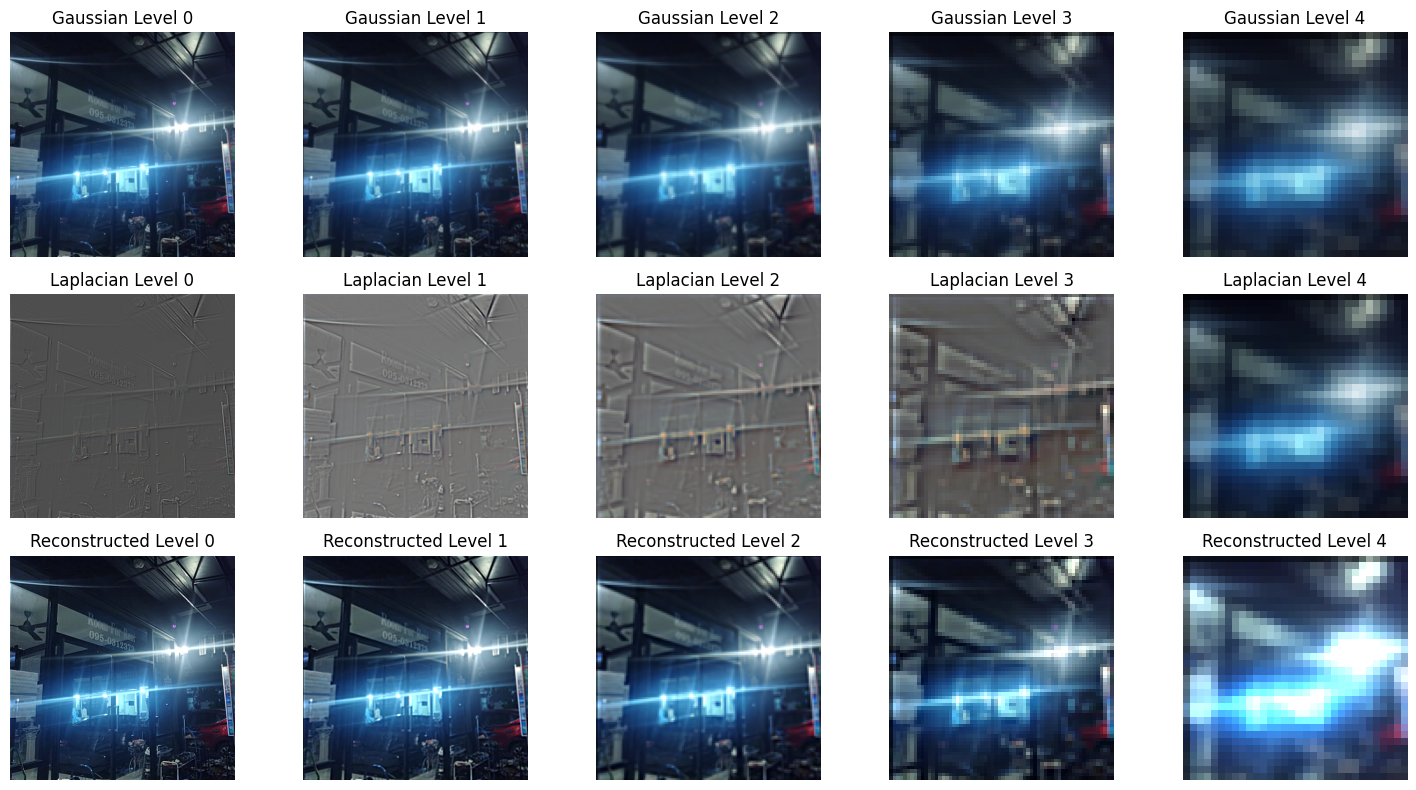

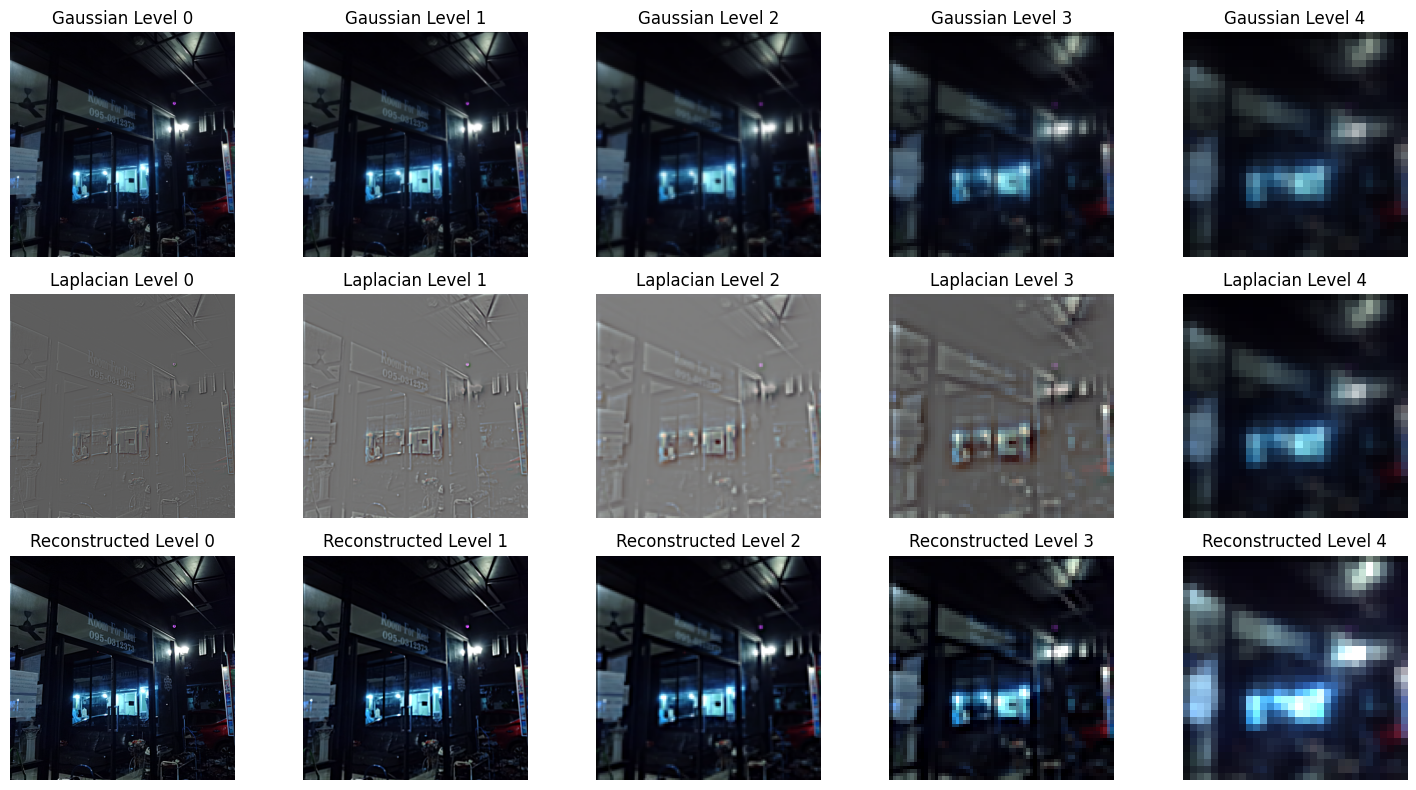

In [21]:
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 读取图像
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image_tensor = torch.from_numpy(np.array(image)).permute(2, 0, 1).float() / 255.0
    return image_tensor.to(device), image

# 下采样（使用高斯模糊+降采样）
def downsample(image_tensor):
    # 高斯模糊核
    kernel = torch.tensor([[1, 4, 6, 4, 1],
                          [4, 16, 24, 16, 4],
                          [6, 24, 36, 24, 6],
                          [4, 16, 24, 16, 4],
                          [1, 4, 6, 4, 1]], dtype=torch.float32, device=device) / 256.0
    kernel = kernel.view(1, 1, 5, 5).repeat(3, 1, 1, 1)

    # 应用高斯模糊
    padding = (2, 2, 2, 2)
    blurred = F.conv2d(image_tensor.unsqueeze(0), kernel, padding=2, groups=3)

    # 降采样（每隔一个像素取一个）
    downsampled = blurred[:, :, ::2, ::2]
    return downsampled.squeeze(0)

    # return -F.max_pool2d(-image_tensor.unsqueeze(0), kernel_size=2, stride=2).squeeze(0)

# 上采样（使用双线性插值）
def upsample(image_tensor, target_size):
    return F.interpolate(image_tensor.unsqueeze(0), size=target_size, 
                         mode='bilinear', align_corners=False).squeeze(0)

# 构建高斯金字塔
def build_gaussian_pyramid(image_tensor, levels=4):
    pyramid = [image_tensor]
    for i in range(levels-1):
        pyramid.append(downsample(pyramid[-1]))
    return pyramid

# 构建拉普拉斯金字塔
def build_laplacian_pyramid(gaussian_pyramid):
    laplacian_pyramid = []
    for i in range(len(gaussian_pyramid)-1):
        upsampled = upsample(gaussian_pyramid[i+1], gaussian_pyramid[i].shape[1:])
        laplacian = gaussian_pyramid[i] - upsampled
        laplacian_pyramid.append(laplacian)
    
    # 最后一级是高斯金字塔的最后一级
    laplacian_pyramid.append(gaussian_pyramid[-1])
    return laplacian_pyramid

# 将张量转换为PIL图像
def tensor_to_pil(tensor):
    tensor = tensor.cpu().detach()
    if tensor.dim() == 3:
        tensor = tensor.permute(1, 2, 0)
    tensor = torch.clamp(tensor, 0, 1)
    array = (tensor.numpy() * 255).astype(np.uint8)
    return Image.fromarray(array)

# 可视化金字塔
def visualize_pyramids(gaussian_pyramid, laplacian_pyramid):
    fig, axes = plt.subplots(3, len(gaussian_pyramid), figsize=(15, 8))
    
    # 显示高斯金字塔
    for i, img_tensor in enumerate(gaussian_pyramid):
        img = tensor_to_pil(img_tensor)
        axes[0, i].imshow(img)
        axes[0, i].set_title(f'Gaussian Level {i}')
        axes[0, i].axis('off')
    
    # 显示拉普拉斯金字塔（需要归一化以便可视化）
    for i, img_tensor in enumerate(laplacian_pyramid):
        # 对拉普拉斯图像进行归一化以便可视化
        laplacian_norm = (img_tensor - img_tensor.min()) / (img_tensor.max() - img_tensor.min() + 1e-8)
        img = tensor_to_pil(laplacian_norm)
        axes[1, i].imshow(img)
        axes[1, i].set_title(f'Laplacian Level {i}')
        axes[1, i].axis('off')
    # 相加
    for i in range(len(gaussian_pyramid)):
        # if i == 0:
        #     recon = laplacian_pyramid[i]
        # else:
        #     recon = upsample(recon, laplacian_pyramid[i].shape[1:]) + laplacian_pyramid[i]
        recon = gaussian_pyramid[i]+ laplacian_pyramid[i]
        # recon = (recon - recon.min()) / (recon.max() - recon.min() + 1e-8)
        recon_img = tensor_to_pil(recon)
        axes[2, i].imshow(recon_img)
        axes[2, i].set_title(f'Reconstructed Level {i}')
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# 主函数
def main(image_path):
    # 加载图像
    image_tensor, original_image = load_image(image_path)
    
    # 构建高斯金字塔
    gaussian_pyramid = build_gaussian_pyramid(image_tensor, levels=5)
    
    # 构建拉普拉斯金字塔
    laplacian_pyramid = build_laplacian_pyramid(gaussian_pyramid)
    
    # 可视化结果
    visualize_pyramids(gaussian_pyramid, laplacian_pyramid)

# 使用示例（需要替换为您的图像路径）
main('E:/dataset/Flare7Kpp/test_data/real/input/input_000054.png')
main('E:/dataset/Flare7Kpp/test_data/real/gt/gt_000054.png')

tensor([[0.0200, 0.0413, 0.0760, 0.1253, 0.1849, 0.2441, 0.2884, 0.3048, 0.2884,
         0.2441, 0.1849, 0.1253, 0.0760, 0.0413, 0.0200],
        [0.0413, 0.0849, 0.1565, 0.2580, 0.3807, 0.5026, 0.5937, 0.6277, 0.5937,
         0.5026, 0.3807, 0.2580, 0.1565, 0.0849, 0.0413],
        [0.0760, 0.1565, 0.2884, 0.4754, 0.7014, 0.9260, 1.0940, 1.1565, 1.0940,
         0.9260, 0.7014, 0.4754, 0.2884, 0.1565, 0.0760],
        [0.1253, 0.2580, 0.4754, 0.7839, 1.1565, 1.5268, 1.8037, 1.9067, 1.8037,
         1.5268, 1.1565, 0.7839, 0.4754, 0.2580, 0.1253],
        [0.1849, 0.3807, 0.7014, 1.1565, 1.7062, 2.2525, 2.6610, 2.8130, 2.6610,
         2.2525, 1.7062, 1.1565, 0.7014, 0.3807, 0.1849],
        [0.2441, 0.5026, 0.9260, 1.5268, 2.2525, 2.9737, 3.5130, 3.7137, 3.5130,
         2.9737, 2.2525, 1.5268, 0.9260, 0.5026, 0.2441],
        [0.2884, 0.5937, 1.0940, 1.8037, 2.6610, 3.5130, 4.1502, 4.3872, 4.1502,
         3.5130, 2.6610, 1.8037, 1.0940, 0.5937, 0.2884],
        [0.3048, 0.6277, 1.

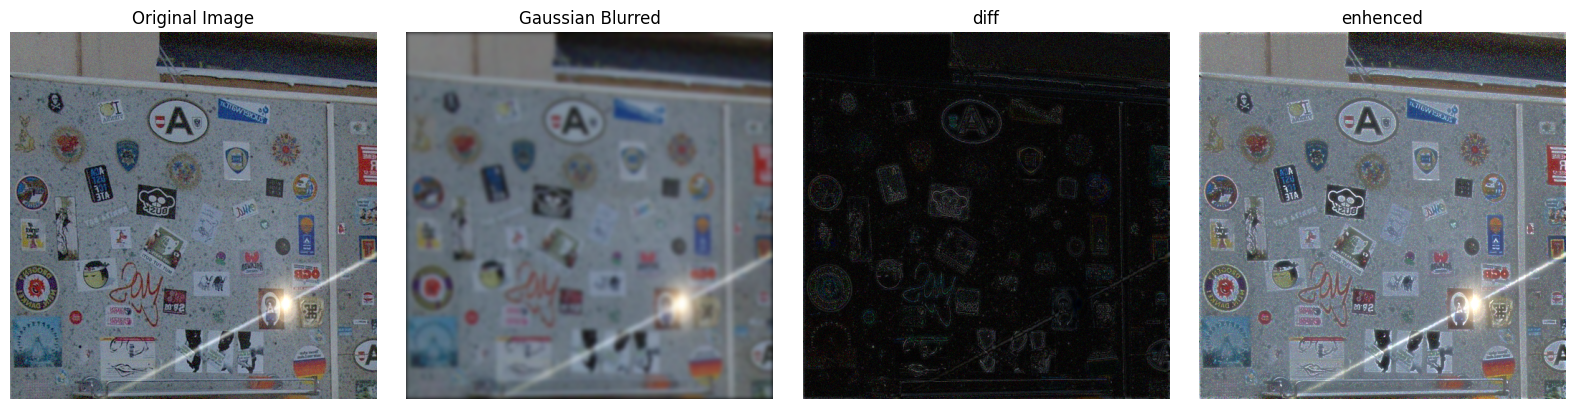

In [10]:
# 导入必要的库
from PIL import Image
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

# 设置图像路径
image_path = "E:/dataset/flare7kpp_r_local/input/c0/48.png"  # 请替换为你的图像路径

# 1. 读取图像
original_image = Image.open(image_path).convert('RGB')

# 2. 将图像转换为PyTorch张量
transform = transforms.ToTensor()
img_tensor = transform(original_image).unsqueeze(0)  # 添加批次维度

# 3. 创建高斯模糊核
def gaussian_kernel(size=5, sigma=1.0):
    """创建高斯核"""
    # 创建坐标网格
    x = torch.arange(size, dtype=torch.float32) - size//2
    y = torch.arange(size, dtype=torch.float32) - size//2
    y, x = torch.meshgrid(y, x, indexing='ij')
    
    # 计算高斯分布
    kernel = torch.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel = kernel / kernel.sum()
    
    return kernel

# 创建高斯核并调整形状以适应卷积操作
kernel_size = 15
sigma = 3.0
gauss_kernel = gaussian_kernel(kernel_size, sigma)
print(gauss_kernel*256)
gauss_kernel = gauss_kernel.view(1, 1, kernel_size, kernel_size)  # 输出通道, 输入通道, 高, 宽
gauss_kernel = gauss_kernel.repeat(3, 1, 1, 1)  # 为每个RGB通道重复核

# 4. 应用高斯模糊
# 对每个通道单独应用高斯模糊
blurred_channels = []
for i in range(3):
    channel = img_tensor[:, i:i+1, :, :]  # 获取单个通道 [batch, channel, height, width]
    blurred_channel = F.conv2d(channel, gauss_kernel[i:i+1], padding=kernel_size//2)
    blurred_channels.append(blurred_channel)

blurred_tensor = torch.cat(blurred_channels, dim=1)

# 5. 计算差值图像
diff_tensor = torch.abs(img_tensor - blurred_tensor)

# 6. 将张量转换回PIL图像
def tensor_to_pil(tensor):
    """将PyTorch张量转换为PIL图像"""
    # 移除批次维度并重新排列维度
    tensor = tensor.squeeze(0).cpu().clone()
    tensor = tensor.clamp(0, 1)  # 确保值在[0,1]范围内
    return transforms.ToPILImage()(tensor)

blurred_image = tensor_to_pil(blurred_tensor)
diff_image = tensor_to_pil(diff_tensor)

# 7. 显示结果
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# 显示原图
axes[0].imshow(np.array(original_image))
axes[0].set_title('Original Image')
axes[0].axis('off')

# 显示模糊后的图像
axes[1].imshow(np.array(blurred_image))
axes[1].set_title('Gaussian Blurred')
axes[1].axis('off')

# 显示模糊后的图像
axes[2].imshow(np.array(diff_image))
axes[2].set_title('diff')
axes[2].axis('off')

enhenced_image = tensor_to_pil(diff_tensor+img_tensor)
# enhenced_image = (enhenced_image - enhenced_image.min()) / (enhenced_image.max() - enhenced_image.min())

# 显示差值图像
axes[3].imshow(np.array(enhenced_image), cmap='gray')
axes[3].set_title('enhenced')
axes[3].axis('off')

plt.tight_layout()
plt.show()

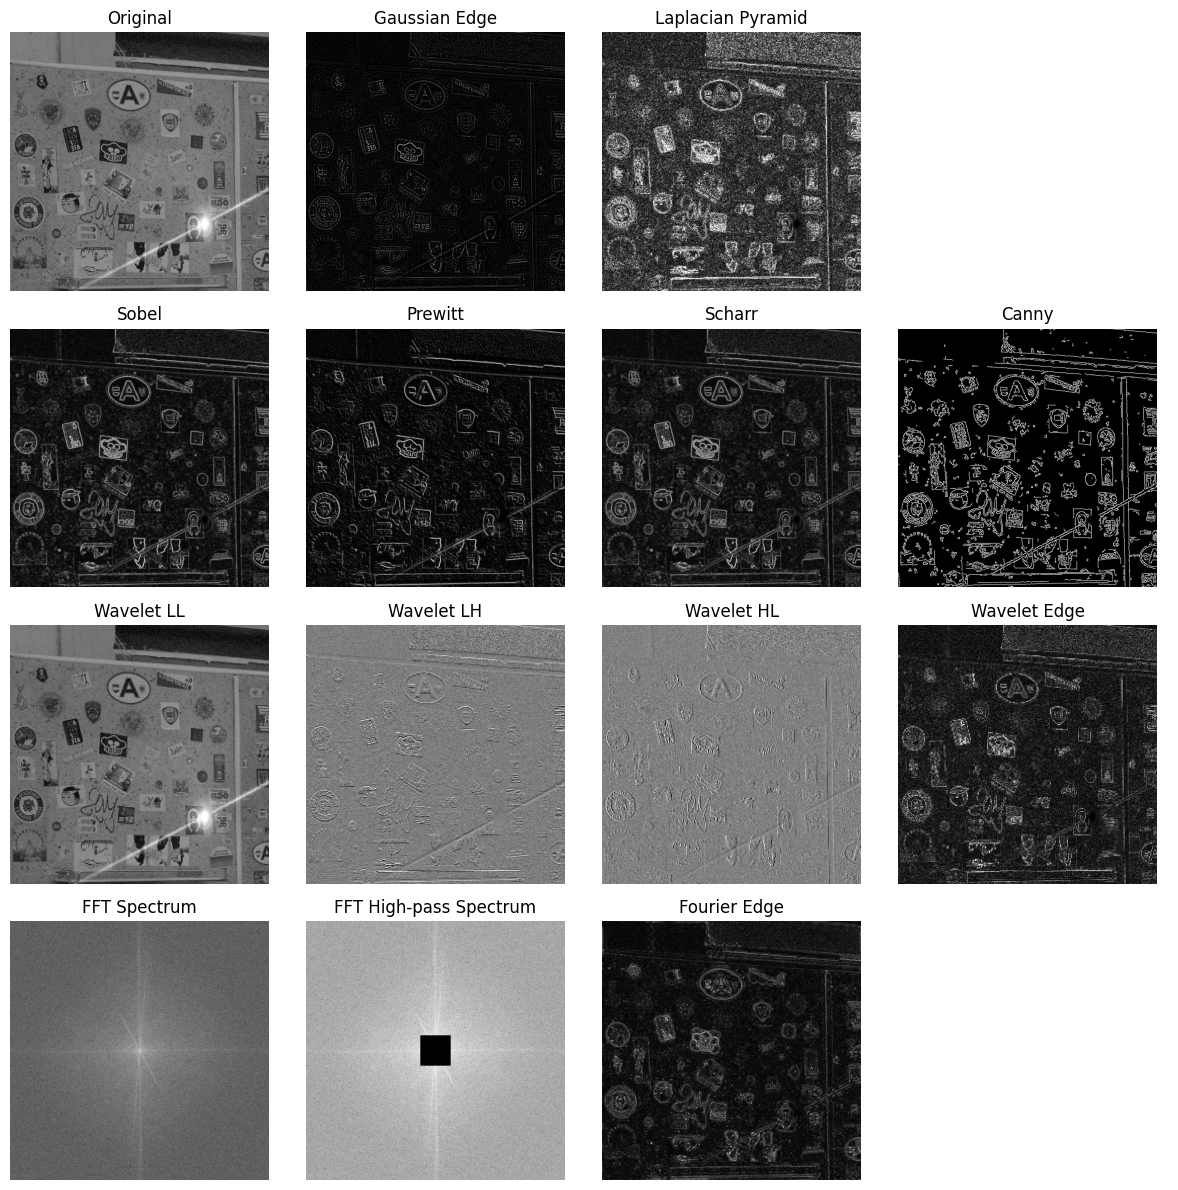

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt

# ========== 读取图像 ==========
# 可以换成自己的图像路径
img = cv2.imread("E:/dataset/flare7kpp_r_local/input/c0/48.png", cv2.IMREAD_GRAYSCALE)

# ========== 第一行：高斯/拉普拉斯金字塔 ==========
# 高斯模糊后做边缘增强（原图 - 高斯模糊）
gaussian_blur = cv2.GaussianBlur(img, (7,7), 1.5)
gaussian_edge = cv2.subtract(img, gaussian_blur)

# 拉普拉斯金字塔近似（用Laplacian做一层近似）
laplacian_pyr = cv2.Laplacian(img, cv2.CV_64F, ksize=3)
laplacian_pyr = cv2.convertScaleAbs(laplacian_pyr)

# ========== 第二行：多种算子 ==========
sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.magnitude(sobelx, sobely)

prewittx = cv2.filter2D(img, -1, np.array([[-1,0,1],[-1,0,1],[-1,0,1]]))
prewitty = cv2.filter2D(img, -1, np.array([[1,1,1],[0,0,0],[-1,-1,-1]]))
prewitt = cv2.magnitude(prewittx.astype(float), prewitty.astype(float))

scharrx = cv2.Scharr(img, cv2.CV_64F, 1, 0)
scharry = cv2.Scharr(img, cv2.CV_64F, 0, 1)
scharr = cv2.magnitude(scharrx, scharry)

canny = cv2.Canny(img, 100, 200)

# ========== 第三行：小波变换 ==========
coeffs2 = pywt.dwt2(img, 'haar')
LL, (LH, HL, HH) = coeffs2
wavelet_edge = np.sqrt(LH**2 + HL**2 + HH**2)

# ========== 第四行：傅里叶变换 ==========
dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

# 设计高通滤波器
rows, cols = img.shape
crow, ccol = rows//2, cols//2
mask = np.ones((rows, cols, 2), np.uint8)
r = 30  # 半径
mask[crow-r:crow+r, ccol-r:ccol+r] = 0

# 滤波
fshift = dft_shift * mask
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
fourier_edge = cv2.magnitude(img_back[:,:,0], img_back[:,:,1])

# ========== 绘图 ==========
fig, axes = plt.subplots(4, 4, figsize=(12,12))

# 第一行
axes[0,0].imshow(img, cmap='gray'); axes[0,0].set_title("Original")
axes[0,1].imshow(gaussian_edge, cmap='gray'); axes[0,1].set_title("Gaussian Edge")
axes[0,2].imshow(laplacian_pyr, cmap='gray'); axes[0,2].set_title("Laplacian Pyramid")
axes[0,3].axis("off")

# 第二行
axes[1,0].imshow(sobel, cmap='gray'); axes[1,0].set_title("Sobel")
axes[1,1].imshow(prewitt, cmap='gray'); axes[1,1].set_title("Prewitt")
axes[1,2].imshow(scharr, cmap='gray'); axes[1,2].set_title("Scharr")
axes[1,3].imshow(canny, cmap='gray'); axes[1,3].set_title("Canny")

# 第三行
axes[2,0].imshow(LL, cmap='gray'); axes[2,0].set_title("Wavelet LL")
axes[2,1].imshow(LH, cmap='gray'); axes[2,1].set_title("Wavelet LH")
axes[2,2].imshow(HL, cmap='gray'); axes[2,2].set_title("Wavelet HL")
axes[2,3].imshow(wavelet_edge, cmap='gray'); axes[2,3].set_title("Wavelet Edge")

# 第四行
axes[3,0].imshow(np.log(1+cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1])), cmap='gray')
axes[3,0].set_title("FFT Spectrum")
axes[3,1].imshow(np.log(1+cv2.magnitude(fshift[:,:,0], fshift[:,:,1])), cmap='gray')
axes[3,1].set_title("FFT High-pass Spectrum")
axes[3,2].imshow(fourier_edge, cmap='gray'); axes[3,2].set_title("Fourier Edge")
axes[3,3].axis("off")

for ax in axes.ravel():
    ax.axis("off")

plt.tight_layout()
plt.show()


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt

# ========== 读取图像 ==========
# 注意：cv2 读进来是 BGR，要转为 RGB
img_bgr = cv2.imread("E:/dataset/flare7kpp_r_local/input/c0/48.png")
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# 一个辅助函数：在 RGB 三通道分别处理后再合并
def apply_per_channel(func, image):
    channels = cv2.split(image)
    processed = [func(c) for c in channels]
    return cv2.merge(processed)

# ========== 第一行：高斯/拉普拉斯金字塔 ==========
gaussian_edge = apply_per_channel(
    lambda c: cv2.subtract(c, cv2.GaussianBlur(c, (7,7), 1.5)), img
)
laplacian_pyr = apply_per_channel(
    lambda c: cv2.convertScaleAbs(cv2.Laplacian(c, cv2.CV_64F, ksize=3)), img
)

# ========== 第二行：多种算子 ==========
sobel = apply_per_channel(
    lambda c: cv2.convertScaleAbs(
        cv2.magnitude(cv2.Sobel(c, cv2.CV_64F,1,0,ksize=3),
                      cv2.Sobel(c, cv2.CV_64F,0,1,ksize=3))
    ), img
)

prewitt = apply_per_channel(
    lambda c: cv2.convertScaleAbs(
        cv2.magnitude(
            cv2.filter2D(c, -1, np.array([[-1,0,1],[-1,0,1],[-1,0,1]]).astype(np.float32)),
            cv2.filter2D(c, -1, np.array([[1,1,1],[0,0,0],[-1,-1,-1]]).astype(np.float32))
        )
    ), img
)

scharr = apply_per_channel(
    lambda c: cv2.convertScaleAbs(
        cv2.magnitude(cv2.Scharr(c, cv2.CV_64F,1,0),
                      cv2.Scharr(c, cv2.CV_64F,0,1))
    ), img
)

canny = apply_per_channel(
    lambda c: cv2.Canny(c, 100, 200), img
)

# ========== 第三行：小波变换 ==========
def wavelet_channel(c):
    coeffs2 = pywt.dwt2(c, 'haar')
    LL, (LH, HL, HH) = coeffs2
    edge = np.sqrt(LH**2 + HL**2 + HH**2)
    edge = np.uint8(255 * edge / edge.max())  # 归一化到 0-255
    return cv2.resize(edge, (c.shape[1], c.shape[0]))

wavelet_edge = apply_per_channel(wavelet_channel, img)

# ========== 第四行：傅里叶变换 ==========
def fourier_channel(c):
    dft = cv2.dft(np.float32(c), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    rows, cols = c.shape
    crow, ccol = rows//2, cols//2
    mask = np.ones((rows, cols, 2), np.uint8)
    r = 30
    mask[crow-r:crow+r, ccol-r:ccol+r] = 0
    fshift = dft_shift * mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    magnitude = cv2.magnitude(img_back[:,:,0], img_back[:,:,1])
    magnitude = np.uint8(255 * magnitude / magnitude.max())
    return magnitude

fourier_edge = apply_per_channel(fourier_channel, img)

# ========== 绘图 ==========
fig, axes = plt.subplots(4, 4, figsize=(12,12))

# 第一行
axes[0,0].imshow(img); axes[0,0].set_title("Original")
axes[0,1].imshow(gaussian_edge); axes[0,1].set_title("Gaussian Edge")
axes[0,2].imshow(laplacian_pyr); axes[0,2].set_title("Laplacian Pyramid")
axes[0,3].axis("off")

# 第二行
axes[1,0].imshow(sobel); axes[1,0].set_title("Sobel")
axes[1,1].imshow(prewitt); axes[1,1].set_title("Prewitt")
axes[1,2].imshow(scharr); axes[1,2].set_title("Scharr")
axes[1,3].imshow(canny); axes[1,3].set_title("Canny")

# 第三行
axes[2,0].imshow(wavelet_edge); axes[2,0].set_title("Wavelet Edge")
axes[2,1].axis("off"); axes[2,2].axis("off"); axes[2,3].axis("off")

# 第四行
axes[3,0].imshow(fourier_edge); axes[3,0].set_title("Fourier Edge")
axes[3,1].axis("off"); axes[3,2].axis("off"); axes[3,3].axis("off")

for ax in axes.ravel():
    ax.axis("off")

plt.tight_layout()
plt.show()


error: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\mathfuncs.cpp:152: error: (-215:Assertion failed) src1.size() == src2.size() && type == src2.type() && (depth == CV_32F || depth == CV_64F) in function 'cv::magnitude'
